In [ ]:
import os, csv, re
import math
import numba
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import os
from anndata import AnnData, read_csv, read_text, read_mtx
from scipy.sparse import issparse
import random
import torch
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from pathlib import Path

def rank_genes_groups(input_adata, target_cluster, nbr_list, label_col, adj_nbr=True, log=False):
    if adj_nbr:
        nbr_list = nbr_list + [target_cluster]
        adata = input_adata[input_adata.obs[label_col].isin(nbr_list)]
    else:
        adata = input_adata.copy()
    adata.var_names_make_unique()
    adata.obs["target"] = ((adata.obs[label_col] == target_cluster) * 1).astype('category')
    sc.tl.rank_genes_groups(adata, groupby="target", reference="rest", n_genes=adata.shape[1], method='wilcoxon')
    pvals_adj = [i[0] for i in adata.uns['rank_genes_groups']["pvals_adj"]]
    genes = [i[1] for i in adata.uns['rank_genes_groups']["names"]]
    if issparse(adata.X):
        obs_tidy = pd.DataFrame(adata.X.A)
    else:
        obs_tidy = pd.DataFrame(adata.X)
    obs_tidy.index = adata.obs["target"].tolist()
    obs_tidy.columns = adata.var.index.tolist()
    obs_tidy = obs_tidy.loc[:, genes]
    # 1. compute mean value
    mean_obs = obs_tidy.groupby(level=0).mean()
    # 2. compute fraction of cells having value >0
    obs_bool = obs_tidy.astype(bool)
    fraction_obs = obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
    # compute fold change.
    if log:  # The adata already logged
        fold_change = np.exp((mean_obs.loc[1] - mean_obs.loc[0]).values)
    else:
        fold_change = (mean_obs.loc[1] / (mean_obs.loc[0] + 1e-9)).values
    df = {'genes': genes, 'in_group_fraction': fraction_obs.loc[1].tolist(),
          "out_group_fraction": fraction_obs.loc[0].tolist(),
          "in_out_group_ratio": (fraction_obs.loc[1] / fraction_obs.loc[0]).tolist(),
          "in_group_mean_exp": mean_obs.loc[1].tolist(), "out_group_mean_exp": mean_obs.loc[0].tolist(),
          "fold_change": fold_change.tolist(), "pvals_adj": pvals_adj}
    df = pd.DataFrame(data=df)
    return df


def find_neighbor_clusters(target_cluster, cell_id, x, y, pred, radius, ratio=1 / 2):
    cluster_num = dict()
    for i in pred:
        cluster_num[i] = cluster_num.get(i, 0) + 1
    df = {'cell_id': cell_id, 'x': x, "y": y, "pred": pred}
    df = pd.DataFrame(data=df)
    df.index = df['cell_id']
    target_df = df[df["pred"] == target_cluster]
    nbr_num = {}
    row_index = 0
    num_nbr = []
    for index, row in target_df.iterrows():
        x = row["x"]
        y = row["y"]
        tmp_nbr = df[((df["x"] - x) ** 2 + (df["y"] - y) ** 2) <= (radius ** 2)]
        # tmp_nbr=df[(df["x"]<x+radius) & (df["x"]>x-radius) & (df["y"]<y+radius) & (df["y"]>y-radius)]
        num_nbr.append(tmp_nbr.shape[0])
        for p in tmp_nbr["pred"]:
            nbr_num[p] = nbr_num.get(p, 0) + 1
    del nbr_num[target_cluster]
    nbr_num_back = nbr_num.copy()  # Backup
    nbr_num = [(k, v) for k, v in nbr_num.items() if v > (ratio * cluster_num[k])]
    nbr_num.sort(key=lambda x: -x[1])
    print("radius=", radius, "average number of neighbors for each spot is", np.mean(num_nbr))
    print(" Cluster", target_cluster, "has neighbors:")
    for t in nbr_num:
        print("Dmain ", t[0], ": ", t[1])
    ret = [t[0] for t in nbr_num]
    flag = False
    if len(ret) == 0:


        nbr_num_back = [(k, v) for k, v in nbr_num_back.items()]
        nbr_num_back.sort(key=lambda x: -x[1])
        ret = [nbr_num_back[0][0]]
        print("No neighbor domain found, only return one potential neighbor domain:", ret)
        print("Try bigger radius or smaller ratio.")
        flag = True
    return ret, flag


def count_nbr(target_cluster, cell_id, x, y, pred, radius):
    adj_2d = calculate_adj_matrix(x=x, y=y)
    cluster_num = dict()
    df = {'cell_id': cell_id, 'x': x, "y": y, "pred": pred}
    df = pd.DataFrame(data=df)
    df.index = df['cell_id']
    target_df = df[df["pred"] == target_cluster]
    row_index = 0
    num_nbr = []
    for index, row in target_df.iterrows():
        x = row["x"]
        y = row["y"]
        tmp_nbr = df[((df["x"] - x) ** 2 + (df["y"] - y) ** 2) <= (radius ** 2)]
        num_nbr.append(tmp_nbr.shape[0])
    return np.mean(num_nbr)


def search_radius(target_cluster, cell_id, x, y, pred, start, end, num_min=8, num_max=15, max_run=100):
    run = 0
    num_low = count_nbr(target_cluster, cell_id, x, y, pred, start)
    num_high = count_nbr(target_cluster, cell_id, x, y, pred, end)
    if num_min <= num_low <= num_max:
        print("recommended radius = ", str(start))
        return start
    elif num_min <= num_high <= num_max:
        print("recommended radius = ", str(end))
        return end
    elif num_low > num_max:
        print("Try smaller start.")
        return None
    elif num_high < num_min:
        print("Try bigger end.")
        return None
    while (num_low < num_min) and (num_high > num_min):
        run += 1
        print("Run " + str(run) + ": radius [" + str(start) + ", " + str(end) + "], num_nbr [" + str(
            num_low) + ", " + str(num_high) + "]")
        if run > max_run:
            print("Exact radius not found, closest values are:\n" + "radius=" + str(start) + ": " + "num_nbr=" + str(
                num_low) + "\nradius=" + str(end) + ": " + "num_nbr=" + str(num_high))
            return None
        mid = (start + end) / 2
        num_mid = count_nbr(target_cluster, cell_id, x, y, pred, mid)
        if num_min <= num_mid <= num_max:
            print("recommended radius = ", str(mid), "num_nbr=" + str(num_mid))
            return mid
        if num_mid < num_min:
            start = mid
            num_low = num_mid
        elif num_mid > num_max:
            end = mid
            num_high = num_mid


@numba.njit("f4(f4[:], f4[:])")
def euclid_dist(t1, t2):
    sum = 0
    for i in range(t1.shape[0]):
        sum += (t1[i] - t2[i]) ** 2
    return np.sqrt(sum)


@numba.njit("f4[:,:](f4[:,:])", parallel=True, nogil=True)
def pairwise_distance(X):
    n = X.shape[0]
    adj = np.empty((n, n), dtype=np.float32)
    for i in numba.prange(n):
        for j in numba.prange(n):
            adj[i][j] = euclid_dist(X[i], X[j])
    return adj


def calculate_adj_matrix(x, y):
    # x,y,x_pixel, y_pixel are lists
    print("Calculateing adj matrix using xy only...")
    X = np.array([x, y]).T.astype(np.float32)
    return pairwise_distance(X)


def detect_SVGs_mode(adata, target, x_name, y_name, domain_name, min_in_group_fraction, min_in_out_group_ratio,
                        min_fold_change, ratio=0.5):
    adj_2d = calculate_adj_matrix(x=adata.obs[x_name].tolist(), y=adata.obs[y_name].tolist())
    start, end = np.quantile(adj_2d[adj_2d != 0], q=0.001), np.quantile(adj_2d[adj_2d != 0], q=0.1)
    r = search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), x=adata.obs[x_name].tolist(),
                      y=adata.obs[y_name].tolist(), pred=adata.obs[domain_name].tolist(), start=start, end=end,
                      num_min=10, num_max=14, max_run=100)
    nbr_domians, flag = find_neighbor_clusters(target_cluster=target,
                                         cell_id=adata.obs.index.tolist(),
                                         x=adata.obs[x_name].tolist(),
                                         y=adata.obs[y_name].tolist(),
                                         pred=adata.obs[domain_name].tolist(),
                                         radius=r,
                                         ratio=ratio)
    if flag:
        return None, flag
    nbr_domians = nbr_domians[0:3]
    de_genes_info = rank_genes_groups(input_adata=adata,
                                      target_cluster=target,
                                      nbr_list=nbr_domians,
                                      label_col=domain_name,
                                      adj_nbr=True,
                                      log=True)
    de_genes_info = de_genes_info[(de_genes_info["pvals_adj"] < 0.05)]
    filtered_info = de_genes_info
    filtered_info = filtered_info[(filtered_info["pvals_adj"] < 0.05) &
                                  (filtered_info["in_out_group_ratio"] > min_in_out_group_ratio) &
                                  (filtered_info["in_group_fraction"] > min_in_group_fraction) &
                                  (filtered_info["fold_change"] > min_fold_change)]
    filtered_info = filtered_info.sort_values(by="in_group_fraction", ascending=False)
    filtered_info["target_dmain"] = target
    filtered_info["neighbors"] = str(nbr_domians)
    print("SVGs for domain ", str(target), ":", filtered_info["genes"].tolist())
    return filtered_info, flag



def find_meta_gene(input_adata,
                   pred,
                   target_domain,
                   start_gene,
                   mean_diff=0,
                   early_stop=True,
                   max_iter=5,
                   use_raw=False):
    meta_name = start_gene
    adata = input_adata.copy()
    adata.obs["meta"] = adata.X[:, adata.var.index == start_gene]
    adata.obs["pred"] = pred
    num_non_target = adata.shape[0]
    for i in range(max_iter):
        #Select cells
        tmp = adata[((adata.obs["meta"] > np.mean(adata.obs[adata.obs["pred"] == target_domain]["meta"])) | (
                    adata.obs["pred"] == target_domain))]
        tmp.obs["target"] = ((tmp.obs["pred"] == target_domain) * 1).astype('category').copy()
        if (len(set(tmp.obs["target"])) < 2) or (np.min(tmp.obs["target"].value_counts().values) < 5):
            print("Meta gene is: ", meta_name)
            return meta_name, adata.obs["meta"].tolist()
        #DE
        sc.tl.rank_genes_groups(tmp, groupby="target", reference="rest", n_genes=1, method='wilcoxon')
        adj_g = tmp.uns['rank_genes_groups']["names"][0][0]
        add_g = tmp.uns['rank_genes_groups']["names"][0][1]
        meta_name_cur = meta_name + "+" + add_g + "-" + adj_g
        print("Add gene: ", add_g)
        print("Minus gene: ", adj_g)
        #Meta gene
        adata.obs[add_g] = adata.X[:, adata.var.index == add_g]
        adata.obs[adj_g] = adata.X[:, adata.var.index == adj_g]
        adata.obs["meta_cur"] = (adata.obs["meta"] + adata.obs[add_g] - adata.obs[adj_g])
        adata.obs["meta_cur"] = adata.obs["meta_cur"] - np.min(adata.obs["meta_cur"])
        mean_diff_cur = np.mean(adata.obs["meta_cur"][adata.obs["pred"] == target_domain]) - np.mean(
            adata.obs["meta_cur"][adata.obs["pred"] != target_domain])
        num_non_target_cur = np.sum(tmp.obs["target"] == 0)
        if (early_stop == False) | ((num_non_target >= num_non_target_cur) & (mean_diff <= mean_diff_cur)):
            num_non_target = num_non_target_cur
            mean_diff = mean_diff_cur
            print("Absolute mean change:", mean_diff)
            print("Number of non-target spots reduced to:", num_non_target)
        else:
            print("Stopped!", "Previous Number of non-target spots", num_non_target, num_non_target_cur, mean_diff,
                  mean_diff_cur)
            print("Previous Number of non-target spots", num_non_target, num_non_target_cur, mean_diff, mean_diff_cur)
            print("Previous Number of non-target spots", num_non_target)
            print("Current Number of non-target spots", num_non_target_cur)
            print("Absolute mean change", mean_diff)
            print("===========================================================================")
            print("Meta gene: ", meta_name)
            print("===========================================================================")
            return meta_name, adata.obs["meta"].tolist()
        meta_name = meta_name_cur
        adata.obs["meta"] = adata.obs["meta_cur"]
        print("===========================================================================")
        print("Meta gene is: ", meta_name)
        print("===========================================================================")
    return meta_name, adata.obs["meta"].tolist()


def detect_meta_genes_mode(adata, target, x_name, y_name, domain_name, start_gene, use_raw=False):
    meta_name, meta_exp = find_meta_gene(input_adata=adata,
                                         pred=adata.obs[domain_name].tolist(),
                                         target_domain=target,
                                         start_gene=start_gene,
                                         mean_diff=0,
                                         early_stop=True,
                                         max_iter=3,
                                         use_raw=use_raw)
    print("Meta gene:", meta_name)
    return meta_name, meta_exp


def plot_meta_genes_mode(adata, x_name, y_name, meta_name, plot_color, size, title="Meta gene", show=False, save=True, save_dir="./"):
    # ax = sc.pl.scatter(adata, alpha=1, x=x_name, y=y_name, color=meta_name, title=title, color_map=plot_color,
    #                   show=show, size=size)

    ax = sc.pl.spatial(adata, color=meta_name, title=title, color_map=plot_color, show=show, size=size, legend_loc=None)
    #ax.set_aspect('equal', 'box')
    # ax.axes.invert_yaxis()

    #if save:
    #    ax.set_axis_off()
    # ax.grid(False)
    plt.savefig(save_dir + "/" + "meta_gene.png", dpi=600)


    plt.close()




def filtered_info_dlpfc(pred, sample_name="151676", target=1, min_in_group_fraction=0.8, min_in_out_group_ratio=1, min_fold_change=1.5, ratio=0.5):
    data_root = Path("D:\\project\\datasets\\DLPFC\\")
    count_file = sample_name + "_filtered_feature_bc_matrix.h5"
    raw_adata = sc.read_visium(data_root / sample_name, count_file=count_file)

    spatial = pd.read_csv("D:/project/datasets/DLPFC_Simple/" + sample_name + "/spatial/tissue_positions_list.csv", sep=",",
        header=None, na_filter=False, index_col=0)

    raw_adata.var_names_make_unique()
    # raw_adata.obs["pred"] = adata.obs[use_rep]
    raw_adata.obs["pred"] = pred
    raw_adata.obs["x1"] = spatial[1]
    raw_adata.obs["x_array"] = spatial[2]
    raw_adata.obs["y_array"] = spatial[3]
    raw_adata.obs["x_pixel"] = spatial[4]
    raw_adata.obs["y_pixel"] = spatial[5]
    # Select captured samples
    raw_adata = raw_adata[raw_adata.obs["x1"] == 1]
    raw_adata.var_names = [i.upper() for i in list(raw_adata.var_names)]
    raw_adata.var["genename"] = raw_adata.var.index.astype("str")
    raw_adata.X = (raw_adata.X.A if issparse(raw_adata.X) else raw_adata.X)
    raw_adata.raw = raw_adata
    sc.pp.log1p(raw_adata)

    filtered_info, flag = detect_SVGs_mode(raw_adata, target=target, x_name="x_array", y_name="y_array",
                                     domain_name="pred", min_in_group_fraction=min_in_group_fraction,
                                     min_in_out_group_ratio=min_in_out_group_ratio, min_fold_change=min_fold_change, ratio=ratio)
    return raw_adata, filtered_info, flag


def svgs_for_brca(adata, target, min_in_group_fraction, min_in_out_group_ratio, min_fold_change):
    raw_adata = sc.read_visium('D:/project/datasets/BRCA1/V1_Human_Breast_Cancer_Block_A_Section_1',
                               count_file='filtered_feature_bc_matrix.h5')
    spatial = pd.read_csv(
        "D:/project/datasets/BRCA1/V1_Human_Breast_Cancer_Block_A_Section_1/spatial/tissue_positions_list.csv", sep=",",
        header=None, na_filter=False, index_col=0)

    raw_adata.var_names_make_unique()
    raw_adata.obs["pred"] = adata.obs['mclust']
    raw_adata.obs["x1"] = spatial[1]
    raw_adata.obs["x_array"] = spatial[2]
    raw_adata.obs["y_array"] = spatial[3]
    raw_adata.obs["x_pixel"] = spatial[4]
    raw_adata.obs["y_pixel"] = spatial[5]
    # Select captured samples
    raw_adata = raw_adata[raw_adata.obs["x1"] == 1]
    raw_adata.var_names = [i.upper() for i in list(raw_adata.var_names)]
    raw_adata.var["genename"] = raw_adata.var.index.astype("str")
    raw_adata.X = (raw_adata.X.A if issparse(raw_adata.X) else raw_adata.X)
    raw_adata.raw = raw_adata
    sc.pp.log1p(raw_adata)

    filtered_info = detect_SVGs_mode(raw_adata, target=target, x_name="x_array", y_name="y_array",
                                        domain_name="pred", min_in_group_fraction=min_in_group_fraction,
                                        min_in_out_group_ratio=min_in_out_group_ratio, min_fold_change=min_fold_change)

    return raw_adata, filtered_info


def svgs_plot(raw_adata, filtered_info, path="./domain1"):
    # Plot refinedspatial domains
    color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370', "#EAE7CC", "#FD1593"], N=256)
    for g in filtered_info["genes"].tolist():
        raw_adata.obs["exp"] = raw_adata.X[:, raw_adata.var.index == g]

        ax = sc.pl.scatter(raw_adata, alpha=1, x="y_pixel", y="x_pixel", color="exp", title=g, color_map=color_self,
                           show=False, size=100000 / raw_adata.shape[0])

        ax.set_aspect('equal', 'box')
        ax.axes.invert_yaxis()
        plt.savefig(path + '/' + g + ".png", dpi=600)
        plt.close()


def svgs_plot2(raw_adata, filtered_info, path="./domain1"):
    # Plot refinedspatial domains
    color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370', "#EAE7CC", "#FD1593"], N=256)
    for g in filtered_info["genes"].tolist():
        fig, ax = plt.subplots(figsize=(4,3))
        raw_adata.obs["exp"] = raw_adata.X[:, raw_adata.var.index == g]

        sc.pl.spatial(raw_adata, color=["exp"], title=g, color_map=color_self, show=False, size=1.5, ax=ax)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(path + '/' + g + "_pdf_.pdf", dpi=600)
        plt.close()


In [2]:
adata = sc.read("./imputeData/OURS_impute_brca_results.h5ad")
adata.layers["recon"] = adata.obsm["CMGAE_recon"]
adata.obs["re_mclust"] = adata.obs["mclust"].values.astype(str)
adata

AnnData object with n_obs × n_vars = 3798 × 4000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust', 're_mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p', 'spatial'
    obsm: 'CMGAE_pred', 'CMGAE_recon', 'spatial'
    layers: 'recon'

In [110]:
target = 20
min_in_group_fraction = 0.8
min_in_out_group_ratio = 1
min_fold_change = 1.5
ratio = 0.5

In [111]:
raw_adata, filtered_info = svgs_for_brca(adata, target=target, min_in_group_fraction=min_in_group_fraction,
                                         min_in_out_group_ratio=min_in_out_group_ratio,
                                         min_fold_change=min_fold_change)

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [1.4142135381698608, 17.262676239013672], num_nbr [1.0, 451.1212121212121]
Calculateing adj matrix using xy only...
Run 2: radius [1.4142135381698608, 9.338444888591766], num_nbr [1.0, 134.78787878787878]
Calculateing adj matrix using xy only...
Run 3: radius [1.4142135381698608, 5.376329213380814], num_nbr [1.0, 44.93939393939394]
Calculateing adj matrix using xy only...
Run 4: radius [1.4142135381698608, 3.395271375775337], num_nbr [1.0, 21.0]
Calculateing adj matrix using xy only...
Run 5: radius [2.404742456972599, 3.395271375775337], num_nbr [9.0, 21.0]
Calculateing adj matrix using xy only...
recommended radius =  2.900006916373968 num_nbr=13.0
radius= 2.900006916373968 average number of neighbors for each spot is 13.0
 Cluster 20 has neighbors:
Dmain  14 :  141
SVGs for domain  20 : ['CRISP3', 'NUCKS1', 'SLITRK6', 'EFNA1', 'PSMA6', 'CACYBP', 'I

In [100]:
len(filtered_info)

2

In [112]:
filtered_info[0]['genes']

0       CRISP3
44      NUCKS1
1      SLITRK6
26       EFNA1
22       PSMA6
40      CACYBP
41        ILF2
42        TPM3
16     S100A14
43       TOMM7
10       CCND1
47        SDC4
48       MGST3
52      CHCHD2
4       SERHL2
2         AGR2
38     TNFSF10
32       CKS1B
46       CPNE7
39        CCT3
53       DEGS1
18        AGR3
17        MPC2
15      SLC1A5
14       AZGP1
9         UGDH
31      ZNF217
19       MUC5B
34      NEDD4L
13      SHISA2
50     SLC44A4
6        GDF15
23       VTCN1
49     TMEM30A
7     C6ORF141
28        MYO6
Name: genes, dtype: object

In [113]:
marker_genes_dict = {
    'Domain 1': ['SPAG6', 'BMERB1', 'ARPP21'],
    'Domain 2': ['CCN1', 'CCL21', 'EHD2'],
    'Domain 10/18': ['C3', 'IGHG1', 'IGLC2'],
    'Domain 11': ['CPB1', 'LINC02224', 'FCGR3B'],
}

In [129]:
marker_genes = marker_genes_dict['Domain 1'] + marker_genes_dict['Domain 2'] + marker_genes_dict['Domain 10/18'] + \
               marker_genes_dict['Domain 11']

In [130]:
mg = pd.Series(marker_genes, name='genes')
mg

0         SPAG6
1        BMERB1
2        ARPP21
3          CCN1
4         CCL21
5          EHD2
6            C3
7         IGHG1
8         IGLC2
9          CPB1
10    LINC02224
11       FCGR3B
Name: genes, dtype: object

In [131]:
domain_path = "./impute_for_svgs/" + "domain_my_Set"

In [133]:
svgs_plot(raw_adata, {'genes': mg}, domain_path)
svgs_plot2(raw_adata, {'genes': mg}, domain_path)

In [186]:
start_gene = marker_genes[0]

In [187]:
meta_name, raw_adata.obs["meta"] = detect_meta_genes_mode(raw_adata, target, x_name="x_array", y_name="y_array",domain_name="pred", start_gene=start_gene, use_raw=False)


Add gene:  CRISP3
Minus gene:  SPAG6
Absolute mean change: 2.5910897
Number of non-target spots reduced to: 782
Meta gene is:  SPAG6+CRISP3-SPAG6
Add gene:  IGKC
Minus gene:  NUPR1
Stopped! Previous Number of non-target spots 782 226 2.5910897 2.5324664
Previous Number of non-target spots 782 226 2.5910897 2.5324664
Previous Number of non-target spots 782
Current Number of non-target spots 226
Absolute mean change 2.5910897
Meta gene:  SPAG6+CRISP3-SPAG6
Meta gene: SPAG6+CRISP3-SPAG6


[<AxesSubplot:title={'center':'[1.09861231]'}, xlabel='spatial1', ylabel='spatial2'>]

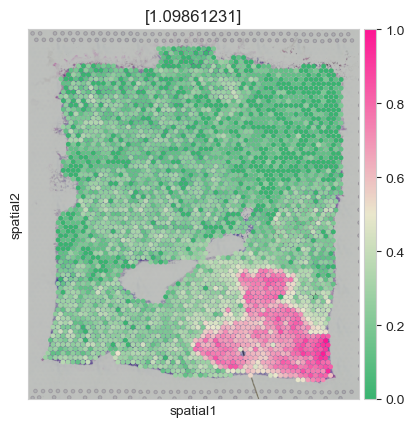

In [188]:

from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as clr
# 获取要归一化的列数据
meta_data = raw_adata.obs['meta'].values.reshape(-1, 1)
# 使用MinMaxScaler进行Min-Max归一化
scaler = MinMaxScaler()
normalized_meta_data = scaler.fit_transform(meta_data)
# 将归一化后的数据更新回原始数据
raw_adata.obs['meta'] = normalized_meta_data.flatten()

color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370', "#EAE7CC", "#FD1593"], N=256)

sc.pl.spatial(raw_adata, color=["meta"], title=meta_data, color_map=color_self, show=False, size=1.5)

In [190]:
adata

AnnData object with n_obs × n_vars = 3798 × 4000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust', 're_mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p', 'spatial'
    obsm: 'CMGAE_pred', 'CMGAE_recon', 'spatial'
    layers: 'recon'

# 基因增强

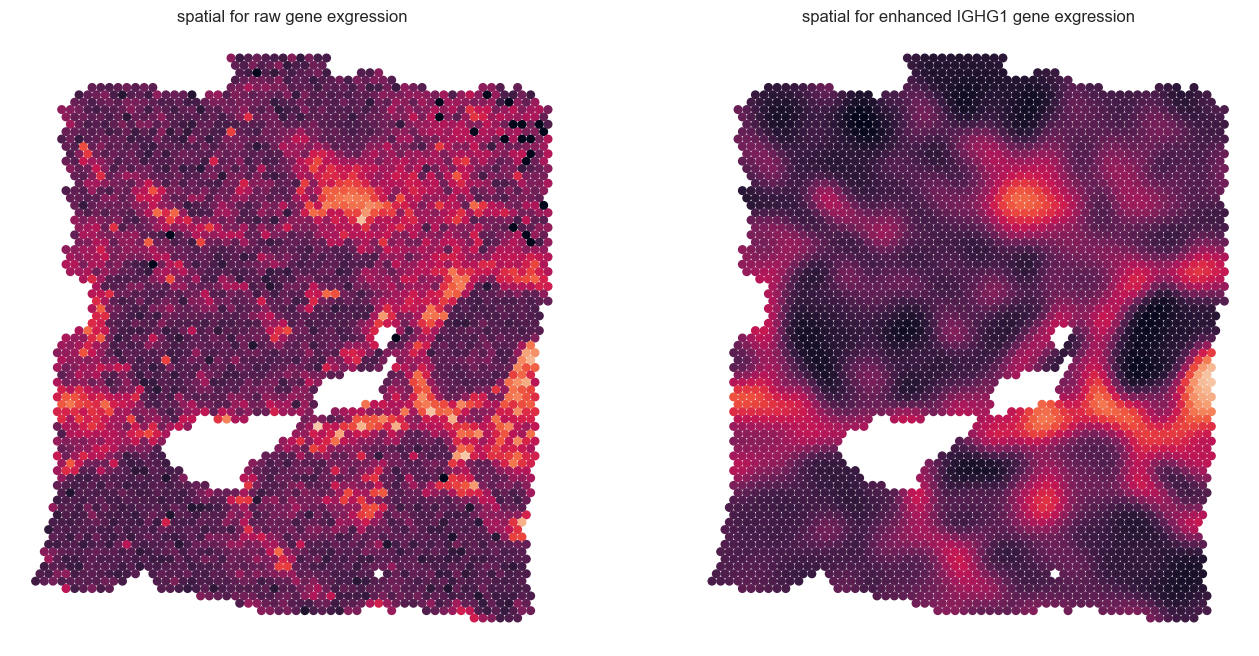

In [192]:
import scanpy as sc
import os
import matplotlib.colors as clr
import matplotlib.pyplot as plt

enhance_adata = adata

# adata =sc.read("./res/BRCA1/OURS_brca_results.h5ad")
gene_markers = ['IGHG1']
for gene_marker in gene_markers:
    if gene_marker not in enhance_adata.var['gene_ids'].index:
        continue
    cxg, cyg = enhance_adata.obs['array_row'], enhance_adata.obs['array_col']
    rawv = enhance_adata[:, gene_marker].X.toarray()
    rawvmax = rawv.max() * 1.1
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].axis('off')
    axs[0].invert_yaxis()
    axs[0].scatter(cyg, cxg, c=rawv, vmax=rawvmax, s=30)
    axs[0].set_title('spatial for raw gene exgression')
    
    recon_data = enhance_adata.copy()
    recon_data.X = recon_data.obsm['CMGAE_recon']
    reconv = recon_data[:, gene_marker].X
    reconvmax = reconv.max() * 1.1
    
    axs[1].axis('off')
    axs[1].invert_yaxis()
    axs[1].scatter(cyg, cxg, c=reconv, vmax=reconvmax, s=30)
    axs[1].set_title('spatial for enhanced '+ gene_marker + ' gene exgression')
    
    # plt.savefig("./output/BRCA1/gene_enhance/" + gene_marker + ".png")

# 基因去噪

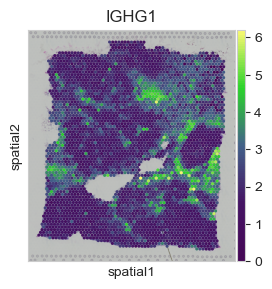

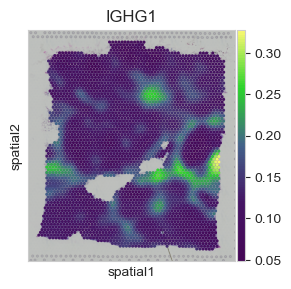

In [196]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plot_color=['#450756','#451464','#426189', '#2BD32B','#F9F871']
newcmp = LinearSegmentedColormap.from_list('new',plot_color, N=100)
marker_Genes = ['VAT1L','PCP4','NEFH', 'CALB1', 'CRYAB']   #GOOD 5 5 4 3  2   0
# marker_Genes = ['VAT1L','PCP4','NEFH', 'CALB1','GNAL', 'CRYAB']  # !!!!!!!!!!151674 用的基因！！！！
# marker_Genes = ['CRYAB','HPCAL1','VAT1L','PCP4','VAMP1','GNAL']
plt.rcParams["figure.figsize"] = (3, 3)

denoise_adata = adata

for gene in ['IGHG1']:
    idx = denoise_adata.var.index.tolist().index(gene)  #输出基因的idx
    
    denoise_adata.obs[f'{gene}(raw)'] = denoise_adata.X.toarray()[:, idx]
    sc.pl.spatial(denoise_adata, img_key="hires", size=1.5,
                  color=f'{gene}(raw)', 
                  title=gene, show=False,
                  color_map=newcmp)
    plt.savefig('./I_FU_' + gene + '_raw.pdf')
    denoise_adata.obs[f'{gene}(Denosing)'] = denoise_adata.layers['recon'][:, idx]
    sc.pl.spatial(denoise_adata, img_key="hires",
                  color=f'{gene}(Denosing)', size=1.5,
                  title=gene, show=False,
                  color_map=newcmp)  
    plt.savefig('./I_FU_' + gene + '_denoising.pdf')